<h3 align="center" style="margin-top: 50px; padding-top: 0;">CQF Exam Two</h3>
<h1 align="center" style="margin-top: 0; padding-top: 0;">Exotic Options Pricing Research</h1>
<h3 align="center" style="margin-top: 0; padding-top: 0;">January 2024 Cohort</h3>
<h4 align="center" style="margin-top: 0; padding-top: 0;">Yingjie Guo</h4>
<h5 align="center" style="margin-top: 0; padding-top: 0;">May 2024</h5>




### Notice: 

- Please note that this document contains all the code that assists the additional report submitted. 
- Note that all boldfaced letters in equations represent vectors instead of single variable.

### Project Description

This is a project on the use of the Monte Carlo scheme to price exotic options to be completed using Python or C++. Use the expected value of the discounted payoff under the risk-neutral density $ \mathbb{Q} $: 

$$
V(S, t) = e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}} [u_i(S_T)]
$$

for the appropriate form of payoff $ u_i $, to consider Asian and lookback options. Use the Euler-Maruyama (only) scheme for initially simulating the underlying stock price. Then vary the data to see the affect on the option price. As an initial example, the following set of sample data may be used:

| Today’s stock price $ S_0 $ | 100 |
|-------------------------------|-----|
| Strike $ E $                | 100 |
| Time to expiry $ (T - t) $  | 1Y  |
| Volatility $ \sigma $       | 20% |
| Constant risk-free interest rate $ r $ | 5% |


--------------------------------------------------------------------------------------------------------------------------------------------------------

<h4 align="center" style="margin-top: 0; padding-top: 0;">Project Research Topic</h4>
<h3 align="center" style="margin-top: 0; padding-top: 0;">Evaluating the Accuracy and Efficiency of Exotic Option Pricing in Markets with Dynamic Volatility Profiles</h3>

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd 
from scipy.stats import norm
import time
from scipy.optimize import fsolve
from IPython.display import display
from IPython.display import display_html
import multiprocessing as mp
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### Set up parameters in Config class 

In [2]:
class Config:
    def __init__(self, S0, rate, sigma, T, days, dt = None, strike = None):
        self.S0 = S0 #initial stock price
        self.rate = rate # constant risk free interest rate
        self.sigma = sigma #Volatility 
        self.T = T #Total time in years (Time to maturity)
        self.days = days #Number of trading days
        self.dt = dt or T/days #Ensure dt aligns with T and days for the case of varying maturities
        self.strike = strike #strike price
        self.disc = np.exp(-rate * T) #Discount factor

    def update_T_and_days(self, T, days):
        self.T = T
        self.days = days
        self.dt = T / days  # Recalculate dt whenever T or days is updated.

### Set up the path simulator - Euler Maruyama
Vectorized version of the path generation is used here to improve the efficiency of the algorithm. Using for loops will take longer
$$\delta S_t = r_t \delta t + \sigma_t \sqrt{\delta t} Z$$


In [3]:
class PathSimulator:
    def __init__(self, config):
        self.config = config

    def generate_path(self):
        #Vectorized path generation using Euler-Maruyama method
        Z = np.random.standard_normal(self.config.days)

        #Calculate the drift and diffusion components 
        drift = (self.config.rate - 0.5 * self.config.sigma ** 2) * self.config.dt
        diffusion = self.config.sigma * np.sqrt(self.config.dt) * Z
        steps = drift + diffusion

        #Generate the path 
        path = self.config.S0 * np.exp(np.cumsum(steps))
        path = np.insert(path, 0, self.config.S0)
        return path

### European Style Exotic Options Pricing

### Asian Options

| Type                | Formula                |
|---------------------|------------------------|
| Floating Strike Call| $\max(S_T - A_T, 0)$   |
| Floating Strike Put | $\max(A_T - S_T, 0)$   |
| Fixed Strike Call   | $\max(A_T - K, 0)$     |
| Fixed Strike Put    | $\max(K - A_T, 0)$     |


In [4]:
class AsianOptionPricer:
    def __init__(self, config):
        self.config = config

    def price_option(self, path, option_type="call", averaging="arithmetic", strike_type="fixed"):
        average_price = self.calculate_average(path, averaging)
        if strike_type == "fixed":
            return self.fixed_strike_payoff(average_price, option_type)
        elif strike_type == "floating":
            return self.floating_strike_payoff(average_price, option_type)

    def calculate_average(self, path, averaging):
        if averaging == "arithmetic":
            return np.mean(path)
        elif averaging == "geometric":
            return np.exp(np.mean(np.log(path)))

    def fixed_strike_payoff(self, average_price, option_type):
        strike = self.config.strike
        if option_type == "call":
            payoff = max(average_price - strike, 0)
        elif option_type == "put":
            payoff = max(strike - average_price, 0)
        return payoff * self.config.disc

    def floating_strike_payoff(self, average_price, option_type):
        strike = average_price
        if option_type == "call":
            payoff = max(self.config.S0 - strike, 0)
        elif option_type == "put":
            payoff = max(strike - self.config.S0, 0)
        return payoff * self.config.disc

### Lookback Options

Definitions:
$$
m_0^T = \min_{0 \leq t \leq T} S_t
$$
$$
M_0^T = \max_{0 \leq t \leq T} S_t
$$

Floating Strike Options:
| Type                | Formula                     |
|---------------------|-----------------------------|
| Floating Strike Call| $\max(S_T - m_0^T, 0) = S_T - m_0^T$   |
| Floating Strike Put | $\max(M_0^T - S_T, 0) = M_0^T - S_T$   |

Fixed Strike Lookback Options:
- Fixed strike lookback call option is a call on the maximum realized price. The terminal payoff is:
$$
\max(M_0^T - K, 0)
$$
- A fixed strike lookback put option is a put on the minimum realized price, and the respective terminal payoff is:
$$
\max(K - m_0^T, 0)
$$


In [5]:
class LookbackOptionPricer:
    def __init__(self, config):
        self.config = config

    def price_fixed_strike(self, path, option_type="call"):
        M_T = np.max(path)
        m_T = np.min(path)
        X = self.config.strike
        if option_type == "call":
            payoff = max(M_T - X, 0)
        elif option_type == "put":
            payoff = max(X - m_T, 0)
        return payoff * self.config.disc

    def price_floating_strike(self, path, option_type="call"):
        S_T = path[-1]
        m_T = np.min(path)
        M_T = np.max(path)
        if option_type == "call":
            payoff = max(S_T - m_T, 0)
        elif option_type == "put":
            payoff = max(M_T - S_T, 0)
        return payoff * self.config.disc

    def price_option(self, path, option_type="call", strike_type="fixed"):
        if strike_type == "fixed":
            return self.price_fixed_strike(path, option_type)
        elif strike_type == "floating":
            return self.price_floating_strike(path, option_type)

### Vanilla Options 
These options are priced for comparison purposes, thus, serving as benchmarks 
The Black-Scholes equation describes the price of the option over time as:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0
$$

Solving the above equation, we know that the value of a call option for a non-dividend paying stock is:
$$
C = S N(d_1) - K e^{-rT} N(d_2)
$$

And, the corresponding put option price is:
$$
P = K e^{-rT} N(-d_2) - S N(-d_1)
$$

Where:
$$
d_1 = \frac{1}{\sigma \sqrt{T}} \left( \ln \left( \frac{S}{K} \right) + \left( r + \frac{\sigma^2}{2} \right) T \right)
$$
$$
d_2 = d_1 - \sigma \sqrt{T}
$$
$$
N(z) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-\frac{1}{2} x^2} \, dx
$$

Definitions:
- $S$ is the spot price of the underlying asset
- $K$ is the strike price
- $r$ is the annualized continuous compounded risk-free rate
- $\sigma$ is the volatility of returns of the underlying asset
- $T$ is time to maturity (expressed in years)
- $N(z)$ is the standard normal cumulative distribution


In [6]:
class BSVanilla:
    def __init__(self, config):
        self.S0 = config.S0  # Initial stock price or spot price
        self.r = config.rate  # Risk-free rate
        self.T = config.T  # Time to maturity

    def d1(self, K, sigma):
        return (np.log(self.S0 / K) + (self.r + 0.5 * sigma ** 2) * self.T) / (sigma * np.sqrt(self.T))

    def d2(self, K, sigma):
        return self.d1(K, sigma) - sigma * np.sqrt(self.T)

    def call_price(self, K, sigma):
        d1 = self.d1(K, sigma)
        d2 = self.d2(K, sigma)
        return self.S0 * norm.cdf(d1) - K * np.exp(-self.r * self.T) * norm.cdf(d2)

    def put_price(self, K, sigma):
        d1 = self.d1(K, sigma)
        d2 = self.d2(K, sigma)
        return K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S0 * norm.cdf(-d1)

    def calculate_prices(self, sigmas, strikes):
        results = []
        for strike in strikes:
            for sigma in sigmas:
                call = self.call_price(strike, sigma)
                put = self.put_price(strike, sigma)
                results.append({
                    'Strike/Sigma': f"{strike}/{sigma}",
                    'black_call': call,
                    'black_put': put
                })
        df = pd.DataFrame(results)
        df = df.set_index('Strike/Sigma')

        # Sorting by first converting Sigma/Strike index to a sortable tuple (sigma, strike)
        # df.index = pd.MultiIndex.from_tuples(
        #     [(float(s.split('/')[0]), int(s.split('/')[1])) for s in df.index],
        #     names=['Strike', 'Sigma']
        # )
        # df = df.sort_values(by=['Sigma', 'Strike'])  # Sorts first by Sigma, then by Strike
        return df

### Simulation Engine and Option Pricing Manager
These two classes are used for managing the simulations and monitoring the visualization layout for clearer presentations of results. 

In [12]:
class SimulationEngine:
    def __init__(self, config, num_paths):
        self.config = config
        self.num_paths = num_paths
        self.simulator = PathSimulator(config)
        self.asian_option_pricer = AsianOptionPricer(config)
        self.lookback_option_pricer = LookbackOptionPricer(config)

    def simulate_and_price_options(self, option_type, averaging, strike_type, option_class="asian"):
        paths = [self.simulator.generate_path() for _ in range(self.num_paths)]
        prices = []
        if option_class == "asian":
            prices = [self.asian_option_pricer.price_option(path, option_type, averaging, strike_type) for path in
                      paths]
        elif option_class == "lookback":
            prices = [self.lookback_option_pricer.price_option(path, option_type, strike_type) for path in paths]
        return np.mean(prices)

    def vary_sigma_and_price_options(self, option_type, averaging, strike_type, sigma_values, option_class="asian"):
        results = {}
        for sigma in sigma_values:
            temp_config = Config(self.config.S0, self.config.rate, sigma, self.config.T,
                                 self.config.days, self.config.dt, self.config.strike)
            temp_engine = SimulationEngine(temp_config, self.num_paths)
            price = temp_engine.simulate_and_price_options(option_type, averaging, strike_type, option_class)
            results[sigma] = price
        return results

    def calculate_standard_error(self, prices):
        M = len(prices)  # Number of paths
        if isinstance(prices, list):
            sample_variance = np.var(prices, ddof=1)  # Correct: Assuming prices is a list of scalars
            standard_error = np.sqrt(sample_variance / M)
            return standard_error
        else:
            raise ValueError("Expected a list of prices")

    def vary_continuous_maturity_and_price_options(self, option_type, averaging, strike_type, option_class="asian",
                                                   min_T=0.1, max_T=1, num_points=50):
        maturities = np.linspace(min_T, max_T, num_points)
        results = {}
        for maturity in maturities:
            temp_config = Config(self.config.S0, self.config.rate, self.config.sigma, maturity,
                                 int(maturity * self.config.days), self.config.dt, self.config.strike)
            temp_engine = SimulationEngine(temp_config, self.num_paths)
            price = temp_engine.simulate_and_price_options(option_type, averaging, strike_type, option_class)
            results[maturity] = price
        return maturities, np.array(list(results.values()))

    def vary_continuous_moneyness_and_price_options(self, option_type, averaging, strike_type, option_class="asian",
                                                    min_level=-0.2, max_level=0.2, num_points=50):
        moneyness_levels = np.linspace(min_level, max_level, num_points)
        results = {}
        for level in moneyness_levels:
            strike_price = self.config.S0 * (1 - level)
            temp_config = Config(self.config.S0, self.config.rate, self.config.sigma, self.config.T,
                                 self.config.days, self.config.dt, strike_price)
            temp_engine = SimulationEngine(temp_config, self.num_paths)
            price = temp_engine.simulate_and_price_options(option_type, averaging, strike_type, option_class)
            results[level] = price
        return moneyness_levels, np.array(list(results.values()))

### Visualization class 
There are two different visualization classes defined here xxxxx 

In [13]:
class Visualizer:

    @staticmethod
    def plot_option_prices(df, title, x_label="Volatility"):
        fig, ax = plt.subplots(figsize=(12, 6))
        df.plot(kind='bar', ax=ax)
        ax.set_title(title)
        ax.set_ylabel("Option Price")
        ax.set_xlabel(x_label)
        ax.tick_params(axis='x', rotation=0)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_analysis(data_dict, variable):
        # Set up the layout: 3 rows for arithmetic, geometric (Asian) and none (Lookback), and 2 columns for fixed and floating
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18), sharex=True, sharey=True)

        # Color mapping for each option type
        color_map = {'Call': 'blue', 'Put': 'red'}

        plot_index = 0
        # Loop over configurations: Asian (Arithmetic, Geometric) and Lookback (None)
        for option_class in ['Asian', 'Lookback']:
            averaging_types = ['Arithmetic', 'Geometric'] if option_class == 'Asian' else [None]
            for averaging in averaging_types:
                for strike_type in ['Fixed', 'Floating']:
                    ax = axes[plot_index // 2, plot_index % 2]
                    for option_type in ['Call', 'Put']:
                        if averaging is None and option_class == 'Lookback':
                            key = f"{option_class} {option_type} None {strike_type}"
                        else:
                            key = f"{option_class} {option_type} {averaging} {strike_type}"
                        x, y = data_dict[key][variable]
                        ax.plot(x, y, marker='o', label=f"{option_type}", color=color_map[option_type])
                    ax.set_title(f"{option_class} {('None' if averaging is None else averaging)} {strike_type}")
                    ax.legend()
                    ax.grid(True)
                    ax.set_xlabel('Maturity' if variable == 'Maturity' else 'Moneyness')
                    ax.set_ylabel('Option Price')
                    plot_index += 1

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_fixed_strike_options_vs_stock_price(config, sigma_values, spot_range, strike=100, option_type="call",
                                                 num_paths=10000, averaging="arithmetic", strike_type="fixed",
                                                 option_class="asian"):
        results = {sigma: [] for sigma in sigma_values}
        for S0 in spot_range:
            for sigma in sigma_values:
                temp_config = Config(S0, config.rate, sigma, config.T, config.days, config.dt, strike)
                temp_engine = SimulationEngine(temp_config, num_paths)
                price = temp_engine.simulate_and_price_options(option_type, averaging, strike_type, option_class)
                results[sigma].append(price)

        # Plotting
        fig, ax = plt.subplots(figsize=(10, 6))
        for sigma in sigma_values:
            ax.plot(spot_range, results[sigma], label=f"σ={sigma}")

        # Marking the strike price for fixed strike types only
        if strike_type == "fixed":
            ax.axvline(x=strike, color='red', linestyle='--', label='Strike Price')

        ax.set_title(f"{option_type.capitalize()} Option Price vs Underlying Stock Price ({strike_type} strike)")
        ax.set_xlabel("Underlying Stock Price")
        ax.set_ylabel("Option Price")
        ax.legend()
        plt.show()

    @staticmethod
    def plot_floating_strike_options_vs_stock_price(config, sigma_values, spot_range, option_type="call", num_paths=10000,
                                                    averaging="arithmetic", strike_type="floating",
                                                    option_class="asian"):
        results = {sigma: [] for sigma in sigma_values}
        for S0 in spot_range:
            for sigma in sigma_values:
                temp_config = Config(S0, config.rate, sigma, config.T, config.days, config.dt, S0)
                temp_engine = SimulationEngine(temp_config, num_paths)
                price = temp_engine.simulate_and_price_options(option_type, averaging, strike_type, option_class)
                results[sigma].append(price)

        # Plotting
        fig, ax = plt.subplots(figsize=(10, 6))
        for sigma in sigma_values:
            ax.plot(spot_range, results[sigma], label=f"σ={sigma}")

        ax.set_title(f"{option_type.capitalize()} Floating Strike Option Price vs Underlying Stock Price")
        ax.set_xlabel("Underlying Stock Price")
        ax.set_ylabel("Option Price")
        ax.legend()
        plt.show()


class ThreeDVisualizer:
    def __init__(self, base_config, num_workers=4):
        self.base_config = base_config
        self.num_workers = num_workers

    def simulation_task(self, config, option_type, averaging, strike_type):
        engine = SimulationEngine(config, 1)  # Assuming 1 path per simulation for demonstration
        return engine.simulate_and_price_options(option_type, averaging, strike_type)

    def collect_and_process_data(self, spot_range, T_range, sigma, option_type, averaging, strike_type, strike):
        # Prepare the grid for processing using the correct indexing order
        S0_grid, T_grid = np.meshgrid(spot_range, T_range, indexing='ij')  # Ensure 'ij' indexing for matrix-like index handling
        prices = np.zeros(S0_grid.shape)

        # Create a list of task parameters for each combination of S0 and T
        tasks = [(Config(S0=S0_grid[i, j], rate=self.base_config.rate, sigma=sigma,
                         T=T_grid[i, j], days=int(252 * T_grid[i, j]), strike=strike),
                  option_type, averaging, strike_type)
                 for i in range(S0_grid.shape[0])
                 for j in range(S0_grid.shape[1])]

        # Use multiprocessing to process each simulation
        with mp.Pool(self.num_workers) as pool:
            results = pool.starmap(self.simulation_task, tasks)

        # Fill the prices matrix with the results
        for k, result in enumerate(results):
            i, j = k // S0_grid.shape[1], k % S0_grid.shape[1]
            prices[i, j] = result

        return S0_grid, T_grid, prices

    def plot_option_prices_3d(self, S0_grid, T_grid, prices):
        # Create a figure and a 3D axes instance
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plotting the surface
        surf = ax.plot_surface(S0_grid, T_grid, prices, cmap='viridis')

        # Adding labels and title
        ax.set_xlabel('Initial Stock Price')
        ax.set_ylabel('Time to Maturity')
        ax.set_zlabel('Option Price')
        ax.set_title('Asian Option Price Surface')

        # Adding a color bar which maps values to colors
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        plt.show()

### Dataframe Management classes 
These classes are created to better manage the presentations of the output dataframes 

In [14]:
class DataFramePrinter:
    def __init__(self, results):
        self.results = results

    def create_dataframe(self):
        data = []
        for config, price in self.results.items():
            option_type, averaging, strike_type, strike, sigma = config.split('|')
            # Create a more readable key for rows, sorting by this later
            row_key = f"{strike}/{sigma}"  # This will make sorting by sigma and strike straightforward
            col_key = f"{option_type}_{averaging}_{strike_type}"  # Clearer column distinction
            data.append({
                'Strike/Sigma': row_key,
                'option_types': col_key,
                'price': price
            })
        df = pd.DataFrame(data)
        pivot_table = df.pivot_table(index='Strike/Sigma', columns='option_types', values='price', aggfunc='first')

        # Sort the index which is in format strike/sigma by sigma then strike
        sorted_index = sorted(pivot_table.index, key=lambda x: (float(x.split('/')[1]), float(x.split('/')[0])))
        pivot_table = pivot_table.reindex(sorted_index)
        # pivot_table = pivot_table.set_index('Strike/Sigma')

        return pivot_table


class DataFrameMerger:
    def __init__(self, dataframes, suffixes):
        """
        Initializes the DataFrameMerger with a list of dataframes and their respective suffixes to add to column names.

        :param dataframes: A dictionary of dataframes with their keys as identifiers.
        :param suffixes: A dictionary of suffixes to add to the column names of the dataframes.
        """
        self.dataframes = dataframes
        self.suffixes = suffixes

    def merge_dataframes(self, keys):
        """
        Merges specified dataframes based on the row names and modifies column names by adding specified suffixes.

        :param keys: List of dataframe keys to merge.
        :return: Merged DataFrame
        """
        # Validate keys
        if any(key not in self.dataframes for key in keys):
            raise ValueError("One or more specified keys do not exist in the provided dataframes.")

        # Start with the first dataframe and rename its columns
        merged_df = self.dataframes[keys[0]].rename(columns=lambda x: x + self.suffixes[keys[0]])

        # Iteratively merge the remaining dataframes
        for key in keys[1:]:
            df_to_merge = self.dataframes[key].rename(columns=lambda x: x + self.suffixes[key])
            merged_df = pd.merge(merged_df, df_to_merge, left_index=True, right_index=True, how='outer')

        return merged_df

### Result Tracking 
This part of the code is used to track pricing results from different runs and to see if the prices generated from each individual run significantly differ from each other. 

In [15]:
class ResultRecorder:
    def __init__(self, config, sigma_values, strike_prices):
        # self.engine = engine
        self.config = config
        self.sigma_values = sigma_values
        self.strike_prices = strike_prices

    def record_options(self, option_class):
        results = {}
        options = ["call", "put"]
        strike_types = ["fixed", "floating"]
        averaging_methods = ["arithmetic", "geometric"] if option_class == "asian" else [None]

        for strike in self.strike_prices:
            for sigma in self.sigma_values:
                temp_config = Config(self.config.S0, self.config.rate, sigma, self.config.T, self.config.days,
                                     self.config.dt, strike)
                engine = SimulationEngine(temp_config, 10000)
                for opt in options:
                    for avg in averaging_methods:
                        for strike_type in strike_types:
                            key = f"{opt}|{avg if avg else 'None'}|{strike_type}|{strike}|{sigma}"
                            price = engine.simulate_and_price_options(opt, avg, strike_type, option_class)
                            results[key] = price
        return results
        
class ResultTracker:
    def __init__(self):
        self.asian_results = {
            "Call Arithmetic Fixed": [],
            "Call Arithmetic Floating": [],
            "Put Arithmetic Fixed": [],
            "Put Arithmetic Floating": [],
            "Call Geometric Fixed": [],
            "Call Geometric Floating": [],
            "Put Geometric Fixed": [],
            "Put Geometric Floating": []
        }
        self.lookback_results = {
            "Call Fixed": [],
            "Call Floating": [],
            "Put Fixed": [],
            "Put Floating": []
        }
    def run_simulations(self, engine, runs=10):
        sigma_values = [0.2, 0.3, 0.5, 0.8]
        for _ in range(runs):
            # Store each run's results as a list of dictionaries
            self.asian_results["Call Arithmetic Fixed"].append(
                engine.vary_sigma_and_price_options("call", "arithmetic", "fixed", sigma_values))
            self.asian_results["Call Arithmetic Floating"].append(
                engine.vary_sigma_and_price_options("call", "arithmetic", "floating", sigma_values))
            self.asian_results["Put Arithmetic Fixed"].append(
                engine.vary_sigma_and_price_options("put", "arithmetic", "fixed", sigma_values))
            self.asian_results["Put Arithmetic Floating"].append(
                engine.vary_sigma_and_price_options("put", "arithmetic", "floating", sigma_values))
            self.asian_results["Call Geometric Fixed"].append(
                engine.vary_sigma_and_price_options("call", "geometric", "fixed", sigma_values))
            self.asian_results["Call Geometric Floating"].append(
                engine.vary_sigma_and_price_options("call", "geometric", "floating", sigma_values))
            self.asian_results["Put Geometric Fixed"].append(
                engine.vary_sigma_and_price_options("put", "geometric", "fixed", sigma_values))
            self.asian_results["Put Geometric Floating"].append(
                engine.vary_sigma_and_price_options("put", "geometric", "floating", sigma_values))
            self.lookback_results["Call Fixed"].append(
                engine.vary_sigma_and_price_options("call", None, "fixed", sigma_values, "lookback"))
            self.lookback_results["Call Floating"].append(
                engine.vary_sigma_and_price_options("call", None, "floating", sigma_values, "lookback"))
            self.lookback_results["Put Fixed"].append(
                engine.vary_sigma_and_price_options("put", None, "fixed", sigma_values, "lookback"))
            self.lookback_results["Put Floating"].append(
                engine.vary_sigma_and_price_options("put", None, "floating", sigma_values, "lookback"))

    #todo: this becomes slow when the number of runs increases
    def plot_results_asian(self):
        sigma_values = [0.2, 0.3, 0.5, 0.8]
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24), sharey=True)
        fig.suptitle('Option Prices Across Different Runs, Volatilities, and Configurations', fontsize=16)

        config_titles = ["Call Arithmetic", "Put Arithmetic", "Call Geometric", "Put Geometric"]
        for i, sigma in enumerate(sigma_values):
            for j, config in enumerate(config_titles):
                ax = axes[i][j]
                keys = [k for k in self.asian_results if k.startswith(config)]
                for key in keys:
                    prices = [run[sigma] for run in self.asian_results[key]]
                    ax.plot(range(1, 11), prices, marker='o', label=f'{key.split(" ")[2]} Strike')
                ax.set_title(f'{config} - Volatility {sigma}')
                ax.set_xlabel('Run Number')
                ax.set_xticks(range(1, 11))
                ax.grid(True)
                if i == 0:
                    ax.legend()

        axes[0][0].set_ylabel('Option Price')
        axes[1][0].set_ylabel('Option Price')
        axes[2][0].set_ylabel('Option Price')
        axes[3][0].set_ylabel('Option Price')

        #This is used for adjusting the layout of the output plot
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.2, hspace=0.5)
        plt.show()

    def plot_results_lookback(self, results_dict, title):
        sigma_values = [0.2, 0.3, 0.5, 0.8]
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6), sharey=True)
        fig.suptitle(title, fontsize=16)
        for i, sigma in enumerate(sigma_values):
            ax = axes[i]
            for key, results in results_dict.items():
                prices = [run[sigma] for run in results]
                ax.plot(range(1, 11), prices, marker='o', label=f'{key}')
            ax.set_title(f'Volatility {sigma}')
            ax.set_xlabel('Run Number')
            ax.set_xticks(range(1, 11))
            ax.grid(True)
            ax.legend()
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.2, hspace=0.5)
        plt.show()

### Main Execution for Exotic Options Pricing Results

### Asian Options

In [16]:
if __name__ == "__main__":
    num_paths = 10000
    np.random.seed(num_paths)
    config = Config(S0=100, rate=0.05, sigma=0.2, T=1, days=252, dt=1/252, strike=100)

    num_workers = 4
    engine = SimulationEngine(config, num_paths)
    sigma_values = [0.05, 0.2, 0.3, 0.5, 0.6, 0.8, 1.0]
    strike_prices = [95, 100, 105]

    # Asian Options
    asian_recorder = ResultRecorder(config, sigma_values, strike_prices)
    asian_results = asian_recorder.record_options("asian")
    asian_printer = DataFramePrinter(asian_results)
    asian_df = asian_printer.create_dataframe()
    print("Asian Option Prices Across Strikes and Volatilities:")
    display(asian_df)

Asian Option Prices Across Strikes and Volatilities:


option_types  call_arithmetic_fixed  call_arithmetic_floating  \
Strike/Sigma                                                    
95/0.05                    7.133601                  0.290309   
100/0.05                   2.709773                  0.314597   
105/0.05                   0.330987                  0.300026   
95/0.2                     8.667515                  3.321219   
100/0.2                    5.787433                  3.236979   
105/0.2                    3.479808                  3.350962   
95/0.3                    10.599491                  5.531260   
100/0.3                    7.917180                  5.413823   
105/0.3                    5.880464                  5.540209   
95/0.5                    14.343623                  9.908891   
100/0.5                   12.037819                  9.865788   
105/0.5                   10.158998                  9.825506   
95/0.6                    17.084256                 12.104178   
100/0.6                   13.967608                 11.924558   
105/0.6                   12.566598                 12.179942   
95/0.8                    20.811468                 16.307771   
100/0.8                   18.294566                 16.224617   
105/0.8                   16.937659                 16.247180   
95/1.0                    25.298504                 19.953148   
100/1.0                   22.515911                 20.637272   
105/1.0                   20.577586                 20.596431   

option_types  call_geometric_fixed  call_geometric_floating  \
Strike/Sigma                                                  
95/0.05                   7.086180                 0.288912   
100/0.05                  2.725042                 0.298422   
105/0.05                  0.329080                 0.305874   
95/0.2                    8.715421                 3.379664   
100/0.2                   5.473335                 3.412277   
105/0.2                   3.343528                 3.426279   
95/0.3                   10.194368                 5.853023   
100/0.3                   7.615344                 5.895942   
105/0.3                   5.488688                 5.707417   
95/0.5                   13.379946                10.682490   
100/0.5                  11.149731                10.821743   
105/0.5                   8.953065                10.839421   
95/0.6                   14.660268                13.196466   
100/0.6                  12.895400                13.185614   
105/0.6                  10.933121                13.194777   
95/0.8                   18.155248                17.894206   
100/0.8                  15.820253                18.342739   
105/0.8                  14.156184                18.427803   
95/1.0                   20.173645                23.384646   
100/1.0                  18.238110                23.989158   
105/1.0                  17.181244                23.880623   

option_types  put_arithmetic_fixed  put_arithmetic_floating  \
Strike/Sigma                                                  
95/0.05                   0.003725                 2.725660   
100/0.05                  0.295979                 2.707339   
105/0.05                  2.644375                 2.698525   
95/0.2                    1.628384                 5.780296   
100/0.2                   3.309800                 5.759658   
105/0.2                   5.942627                 5.773205   
95/0.3                    3.409609                 8.002024   
100/0.3                   5.597524                 7.796527   
105/0.3                   8.083708                 8.162521   
95/0.5                    7.584903                12.690571   
100/0.5                   9.954431                12.412467   
105/0.5                  12.968823                12.636157   
95/0.6                    9.526156                14.204887   
100/0.6                  12.033559                14.283927   
105/0.6                  14.854199            

### Lookback Options

In [17]:
if __name__ == "__main__":
    # Lookback Options
    lookback_recorder = ResultRecorder(config, sigma_values, strike_prices)
    lookback_results = lookback_recorder.record_options("lookback")
    lookback_printer = DataFramePrinter(lookback_results)
    lookback_df = lookback_printer.create_dataframe()
    print("Lookback Option Prices Across Strikes and Volatilities:")
    display(lookback_df)

Lookback Option Prices Across Strikes and Volatilities:


option_types  call_None_fixed  call_None_floating  put_None_fixed  \
Strike/Sigma                                                        
95/0.05             11.549232            6.679982        0.124498   
100/0.05             6.841264            6.740654        1.848185   
105/0.05             2.785395            6.666238        6.573580   
95/0.2              23.017270           16.660472        7.663316   
100/0.2             18.377436           16.675164       11.683922   
105/0.2             14.602038           16.667634       16.599852   
95/0.3              31.239884           22.779549       14.050296   
100/0.3             26.685371           22.721249       17.888782   
105/0.3             22.229525           22.654390       22.977988   
95/0.5              50.731042           34.729182       25.115995   
100/0.5             46.161510           34.795062       29.451736   
105/0.5             41.140532           33.777372       34.320354   
95/0.6              60.264561           40.323499       30.651628   
100/0.6             56.110701           39.933802       35.073016   
105/0.6             51.040454           40.813824       39.801145   
95/0.8              82.186187           48.732969       39.844292   
100/0.8             77.293876           49.190579       44.634995   
105/0.8             72.997794           48.472690       49.141785   
95/1.0             103.215205           56.212977       48.010870   
100/1.0            100.579335           58.689216       52.819956   
105/1.0             97.121661           57.544964       57.717939   

option_types  put_None_floating  
Strike/Sigma                     
95/0.05                1.938490  
100/0.05               1.944162  
105/0.05               1.951095  
95/0.2                13.458293  
100/0.2               13.473258  
105/0.2               13.277474  
95/0.3                21.739796  
100/0.3               21.976343  
105/0.3               21.985939  
95/0.5                40.225313  
100/0.5               40.477841  
105/0.5               40.778634  
95/0.6                50.693488  
100/0.6               50.692511  
105/0.6               50.489696  
95/0.8                71.190658  
100/0.8               72.261071  
105/0.8               71.533045  
95/1.0                95.069337  
100/1.0               95.808442  
105/1.0               96.618350

### Merge Results with Vanilla Option Pricing Results

In [18]:
if __name__ == "__main__":
    # The Black-Scholes Vanilla option pricer
    bs_vanilla = BSVanilla(config)
    vanilla_df = bs_vanilla.calculate_prices(sigma_values, strike_prices)
    print("European Vanilla Option Prices Across Strikes and Volatilities:")
    #dataframes editing for result output
    dataframes = {
        'asian': asian_df,
        'lookback': lookback_df,
        'vanilla': vanilla_df}
    suffixes = {
        'asian': '_asian',
        'lookback': '_lookback',
        'vanilla': '_vanilla'}

    # Initialize the DataFrameMerger
    merger = DataFrameMerger(dataframes, suffixes)

    # Specify the keys of the dataframes you want to merge
    overall_df = merger.merge_dataframes(['asian', 'lookback', 'vanilla'])
    display(overall_df)

European Vanilla Option Prices Across Strikes and Volatilities:


call_arithmetic_fixed_asian  call_arithmetic_floating_asian  \
Strike/Sigma                                                                
100/0.05                         2.709773                        0.314597   
100/0.2                          5.787433                        3.236979   
100/0.3                          7.917180                        5.413823   
100/0.5                         12.037819                        9.865788   
100/0.6                         13.967608                       11.924558   
100/0.8                         18.294566                       16.224617   
100/1.0                         22.515911                       20.637272   
105/0.05                         0.330987                        0.300026   
105/0.2                          3.479808                        3.350962   
105/0.3                          5.880464                        5.540209   
105/0.5                         10.158998                        9.825506   
105/0.6                         12.566598                       12.179942   
105/0.8                         16.937659                       16.247180   
105/1.0                         20.577586                       20.596431   
95/0.05                          7.133601                        0.290309   
95/0.2                           8.667515                        3.321219   
95/0.3                          10.599491                        5.531260   
95/0.5                          14.343623                        9.908891   
95/0.6                          17.084256                       12.104178   
95/0.8                          20.811468                       16.307771   
95/1.0                          25.298504                       19.953148   

              call_geometric_fixed_asian  call_geometric_floating_asian  \
Strike/Sigma                                                              
100/0.05                        2.725042                       0.298422   
100/0.2                         5.473335                       3.412277   
100/0.3                         7.615344                       5.895942   
100/0.5                        11.149731                      10.821743   
100/0.6                        12.895400                      13.185614   
100/0.8                        15.820253                      18.342739   
100/1.0                        18.238110                      23.989158   
105/0.05                        0.329080                       0.305874   
105/0.2                         3.343528                       3.426279   
105/0.3                         5.488688                       5.707417   
105/0.5                         8.953065                      10.839421   
105/0.6                        10.933121                      13.194777   
105/0.8                        14.156184                      18.427803   
105/1.0                        17.181244                      23.880623   
95/0.05                         7.086180                       0.288912   
95/0.2                          8.715421                       3.379664   
95/0.3                         10.194368                       5.853023   
95/0.5                         13.379946                      10.682490   
95/0.6                         14.660268                      13.196466   
95/0.8                         18.155248                      17.894206   
95/1.0                         20.173645                      23.384646   

              put_arithmetic_fixed_asian  put_arithmetic_floating_asian  \
Strike/Sigma                                                              
100/0.05                        0.295979                       2.707339   
100/0.2                         3.309800                       5.759658   
100/0.3                         5.597524                       7.796527   
100/0.5                         9.954431                      12.412467   
100/0.6                        12.033559                      14.2

### Visualization of the Results 

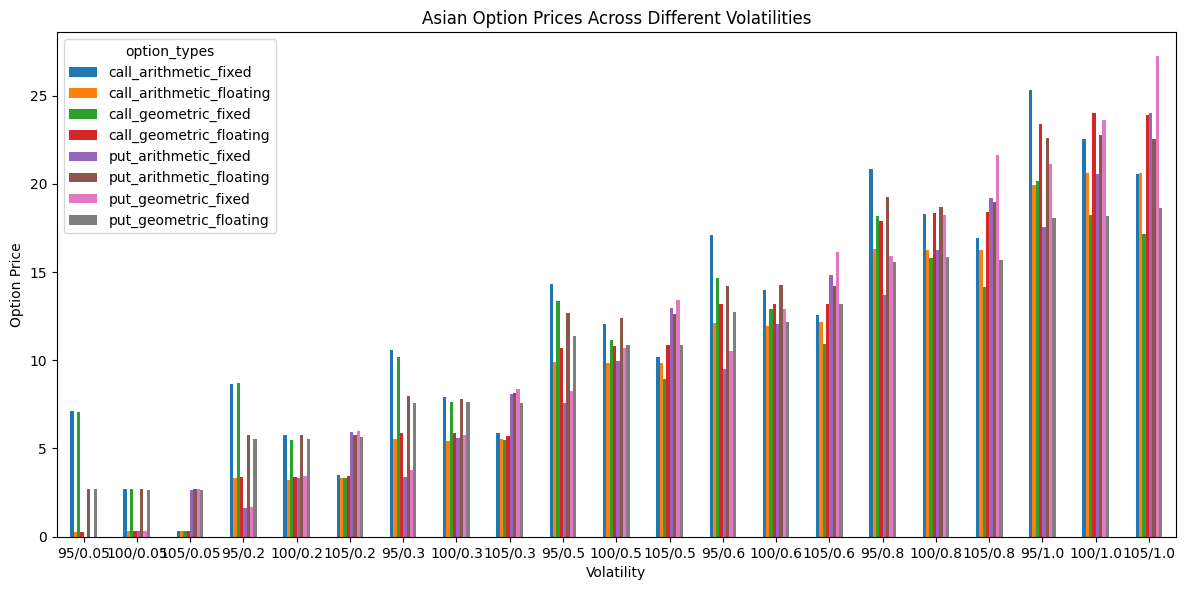

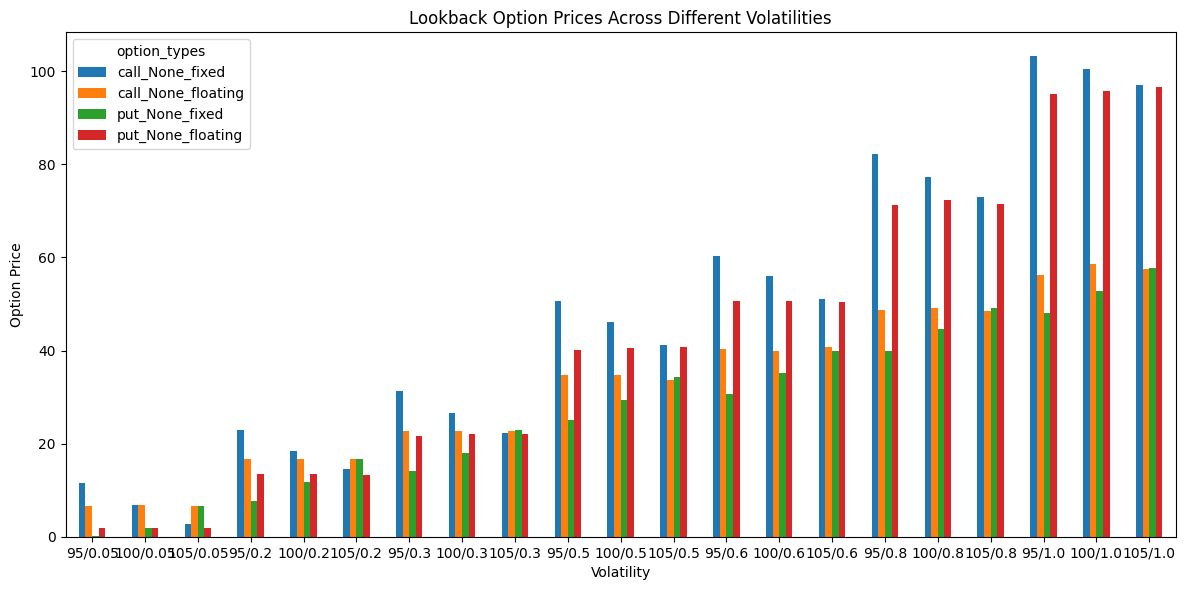

In [19]:
if __name__ == "__main__":
    # Visualize the results
    vis = Visualizer()
    asian_df = asian_printer.create_dataframe()
    lookback_df = lookback_printer.create_dataframe()

    vis.plot_option_prices(asian_df, "Asian Option Prices Across Different Volatilities")
    vis.plot_option_prices(lookback_df, "Lookback Option Prices Across Different Volatilities")

### Asian Options Plots 

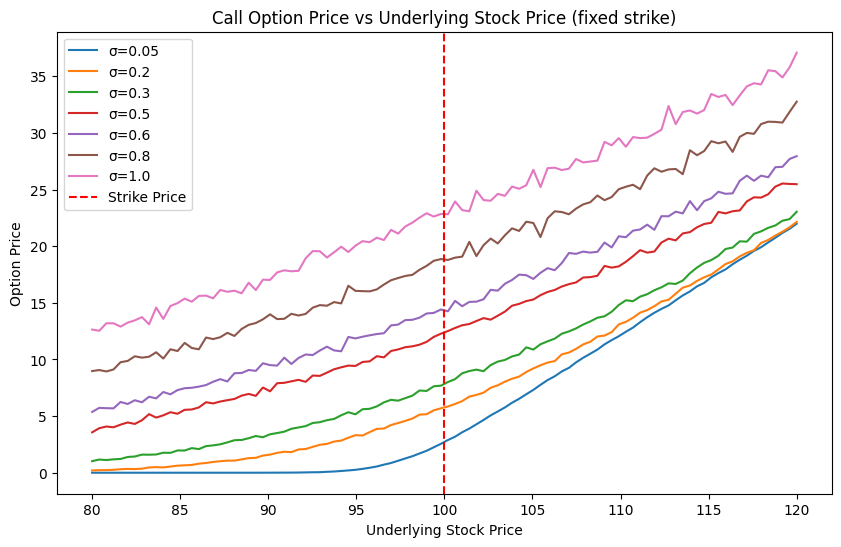

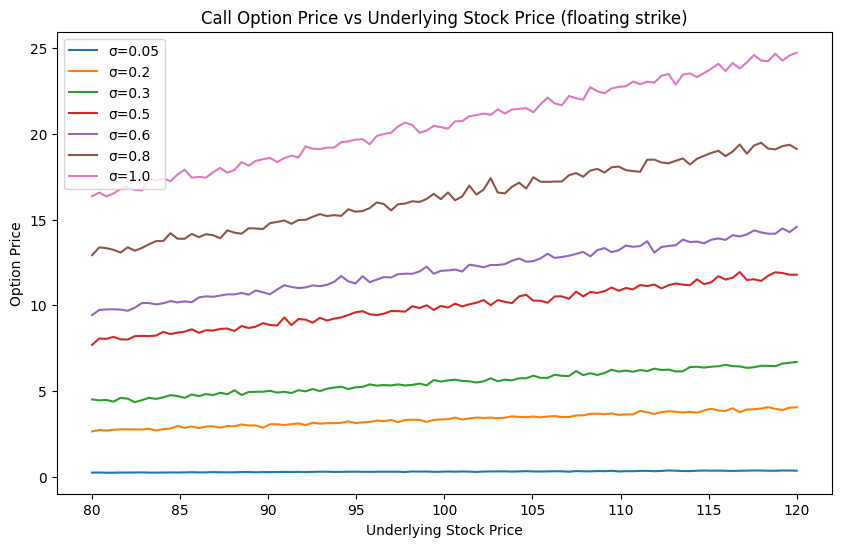

In [21]:
if __name__ == "__main__":
    #Option value versus underlying asset plots
    spot_range = np.linspace(80, 120, 100)  # Configurable range of spot pricesd
    option_type = "call"  # Can be changed to "call"
    # Fixed Strike Call or Put Options
    Visualizer.plot_fixed_strike_options_vs_stock_price(config, sigma_values, spot_range, strike=100,
                                                        option_type=option_type, num_paths=10000, averaging="arithmetic",
                                                        strike_type="fixed", option_class="asian")
    Visualizer.plot_fixed_strike_options_vs_stock_price(config, sigma_values, spot_range, strike=100,
                                                        option_type=option_type, num_paths=10000, averaging="arithmetic",
                                                        strike_type="floating", option_class="asian")

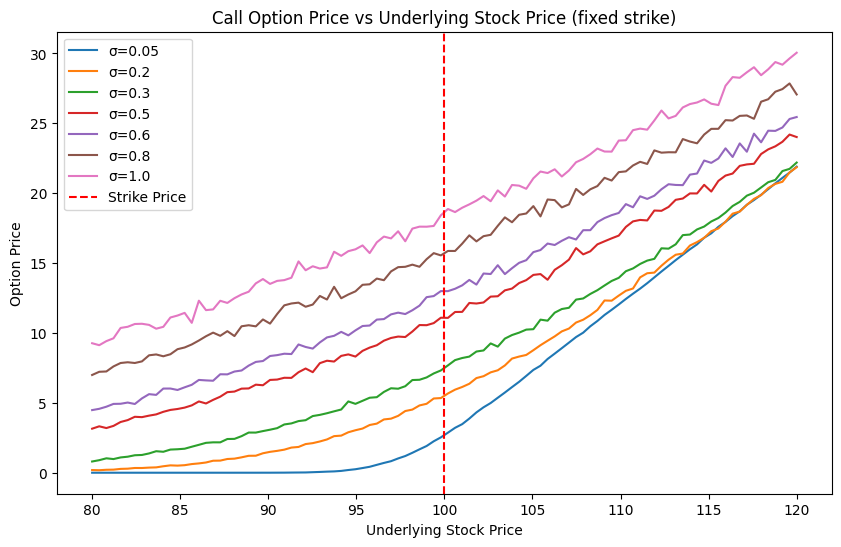

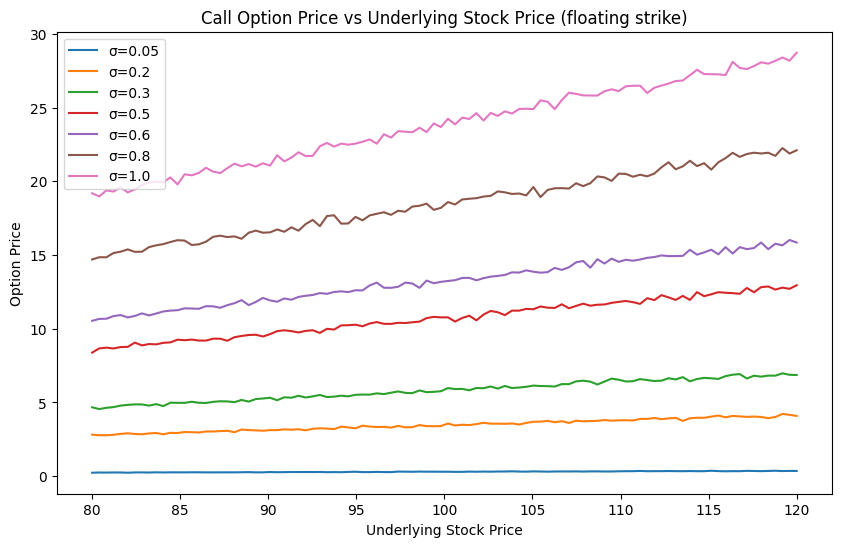

In [68]:
if __name__ == "__main__":
    #Option value versus underlying asset plots
    spot_range = np.linspace(80, 120, 100)  # Configurable range of spot pricesd
    option_type = "call"  # Can be changed to "call"
    # Fixed Strike Call or Put Options
    Visualizer.plot_fixed_strike_options_vs_stock_price(config, sigma_values, spot_range, strike=100,
                                                        option_type=option_type, num_paths=10000, averaging="geometric",
                                                        strike_type="fixed", option_class="asian")
    Visualizer.plot_fixed_strike_options_vs_stock_price(config, sigma_values, spot_range, strike=100,
                                                        option_type=option_type, num_paths=10000, averaging="geometric",
                                                        strike_type="floating", option_class="asian")

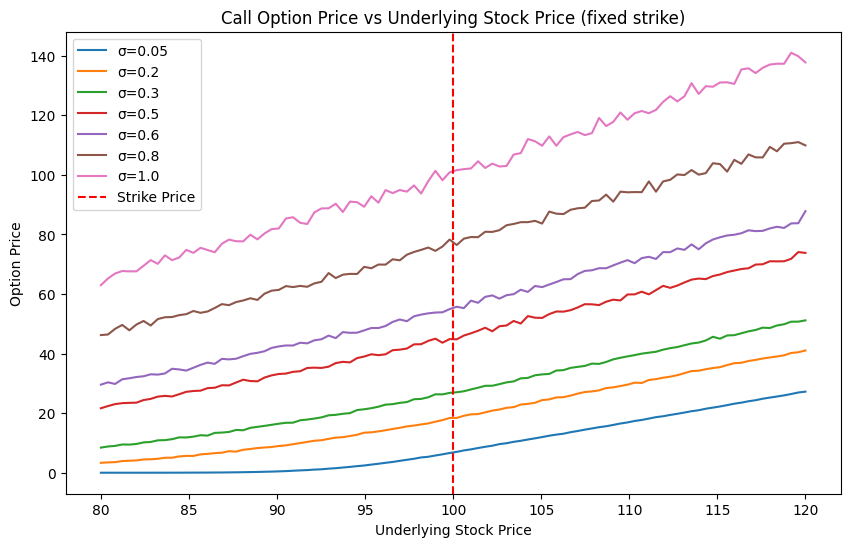

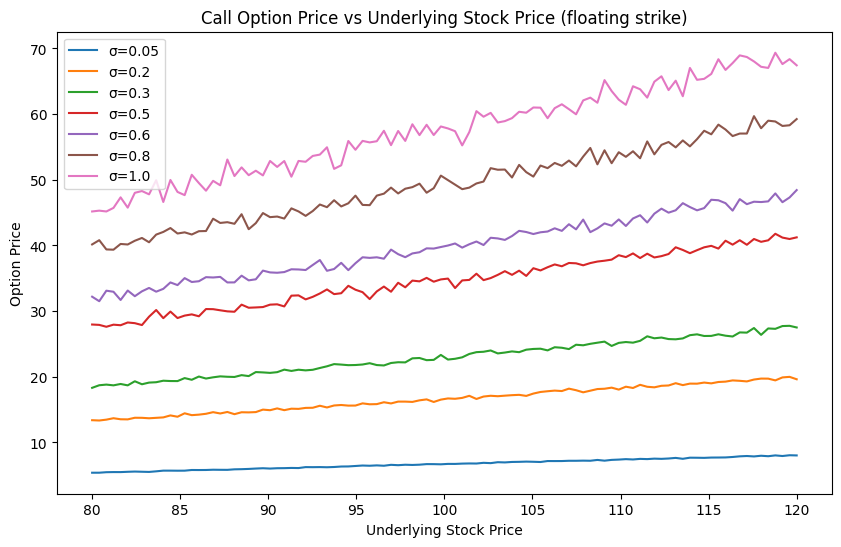

In [22]:
if __name__ == "__main__":
    #Option value versus underlying asset plots
    spot_range = np.linspace(80, 120, 100)  # Configurable range of spot pricesd
    option_type = "call"  # Can be changed to "call"
    # Fixed Strike Call or Put Options
    Visualizer.plot_fixed_strike_options_vs_stock_price(config, sigma_values, spot_range, strike=100,
                                                        option_type=option_type, num_paths=10000, averaging="geometric",
                                                        strike_type="fixed", option_class="lookback")
    Visualizer.plot_fixed_strike_options_vs_stock_price(config, sigma_values, spot_range, strike=100,
                                                        option_type=option_type, num_paths=10000, averaging="geometric",
                                                        strike_type="floating", option_class="lookback")

### Standard Error Analysis of Monte Carlo Simulation 

In [20]:
if __name__ == "__main__":
    num_paths = 10000
    results = []
    option_types = ['call', 'put']
    averagings = ['arithmetic', 'geometric']
    strike_types = ['fixed', 'floating']

    for option_type in option_types:
        for averaging in averagings:
            for strike_type in strike_types:
                prices = []
                for _ in range(num_paths):
                    path = engine.simulator.generate_path()
                    price = engine.asian_option_pricer.price_option(path, option_type=option_type,
                                                                    averaging=averaging, strike_type=strike_type)
                    prices.append(price)

                average_price = np.mean(prices)
                standard_error = engine.calculate_standard_error(prices)

                # Collecting results for the current configuration
                results.append({
                    'Option Type': option_type,
                    'Averaging': averaging,
                    'Strike Type': strike_type,
                    'Standard Error': standard_error
                })

    # Creating a DataFrame from the results
    df_results_error_analysis = pd.DataFrame(results)
    display(df_results_error_analysis)

Option Type   Averaging Strike Type  Standard Error
0        call  arithmetic       fixed        0.079586
1        call  arithmetic    floating        0.053402
2        call   geometric       fixed        0.076098
3        call   geometric    floating        0.053701
4         put  arithmetic       fixed        0.052618
5         put  arithmetic    floating        0.079639
6         put   geometric       fixed        0.053348
7         put   geometric    floating        0.076816

### 3D plot: Spot Price, Time to Maturity, Option Value

In [ ]:
if __name__ == "__main__":
    # Create the Visualization object
    tdvisualizer = ThreeDVisualizer(config, num_workers=4)
    # Plotting the 3D graph
    T_range = np.linspace(0.1, 1, 10)  # From 0.1 to 1 year in 10 steps
    # Plot for Asian Call options
    S0_grid, T_grid, prices = tdvisualizer.collect_and_process_data(spot_range, T_range, sigma = 0.8, option_type="call",
                                                                  averaging="geometric", strike_type="fixed",
                                                                  strike= 100)
    tdvisualizer.plot_option_prices_3d(S0_grid, T_grid, prices)

### Price Stability Convergence for 10 Runs

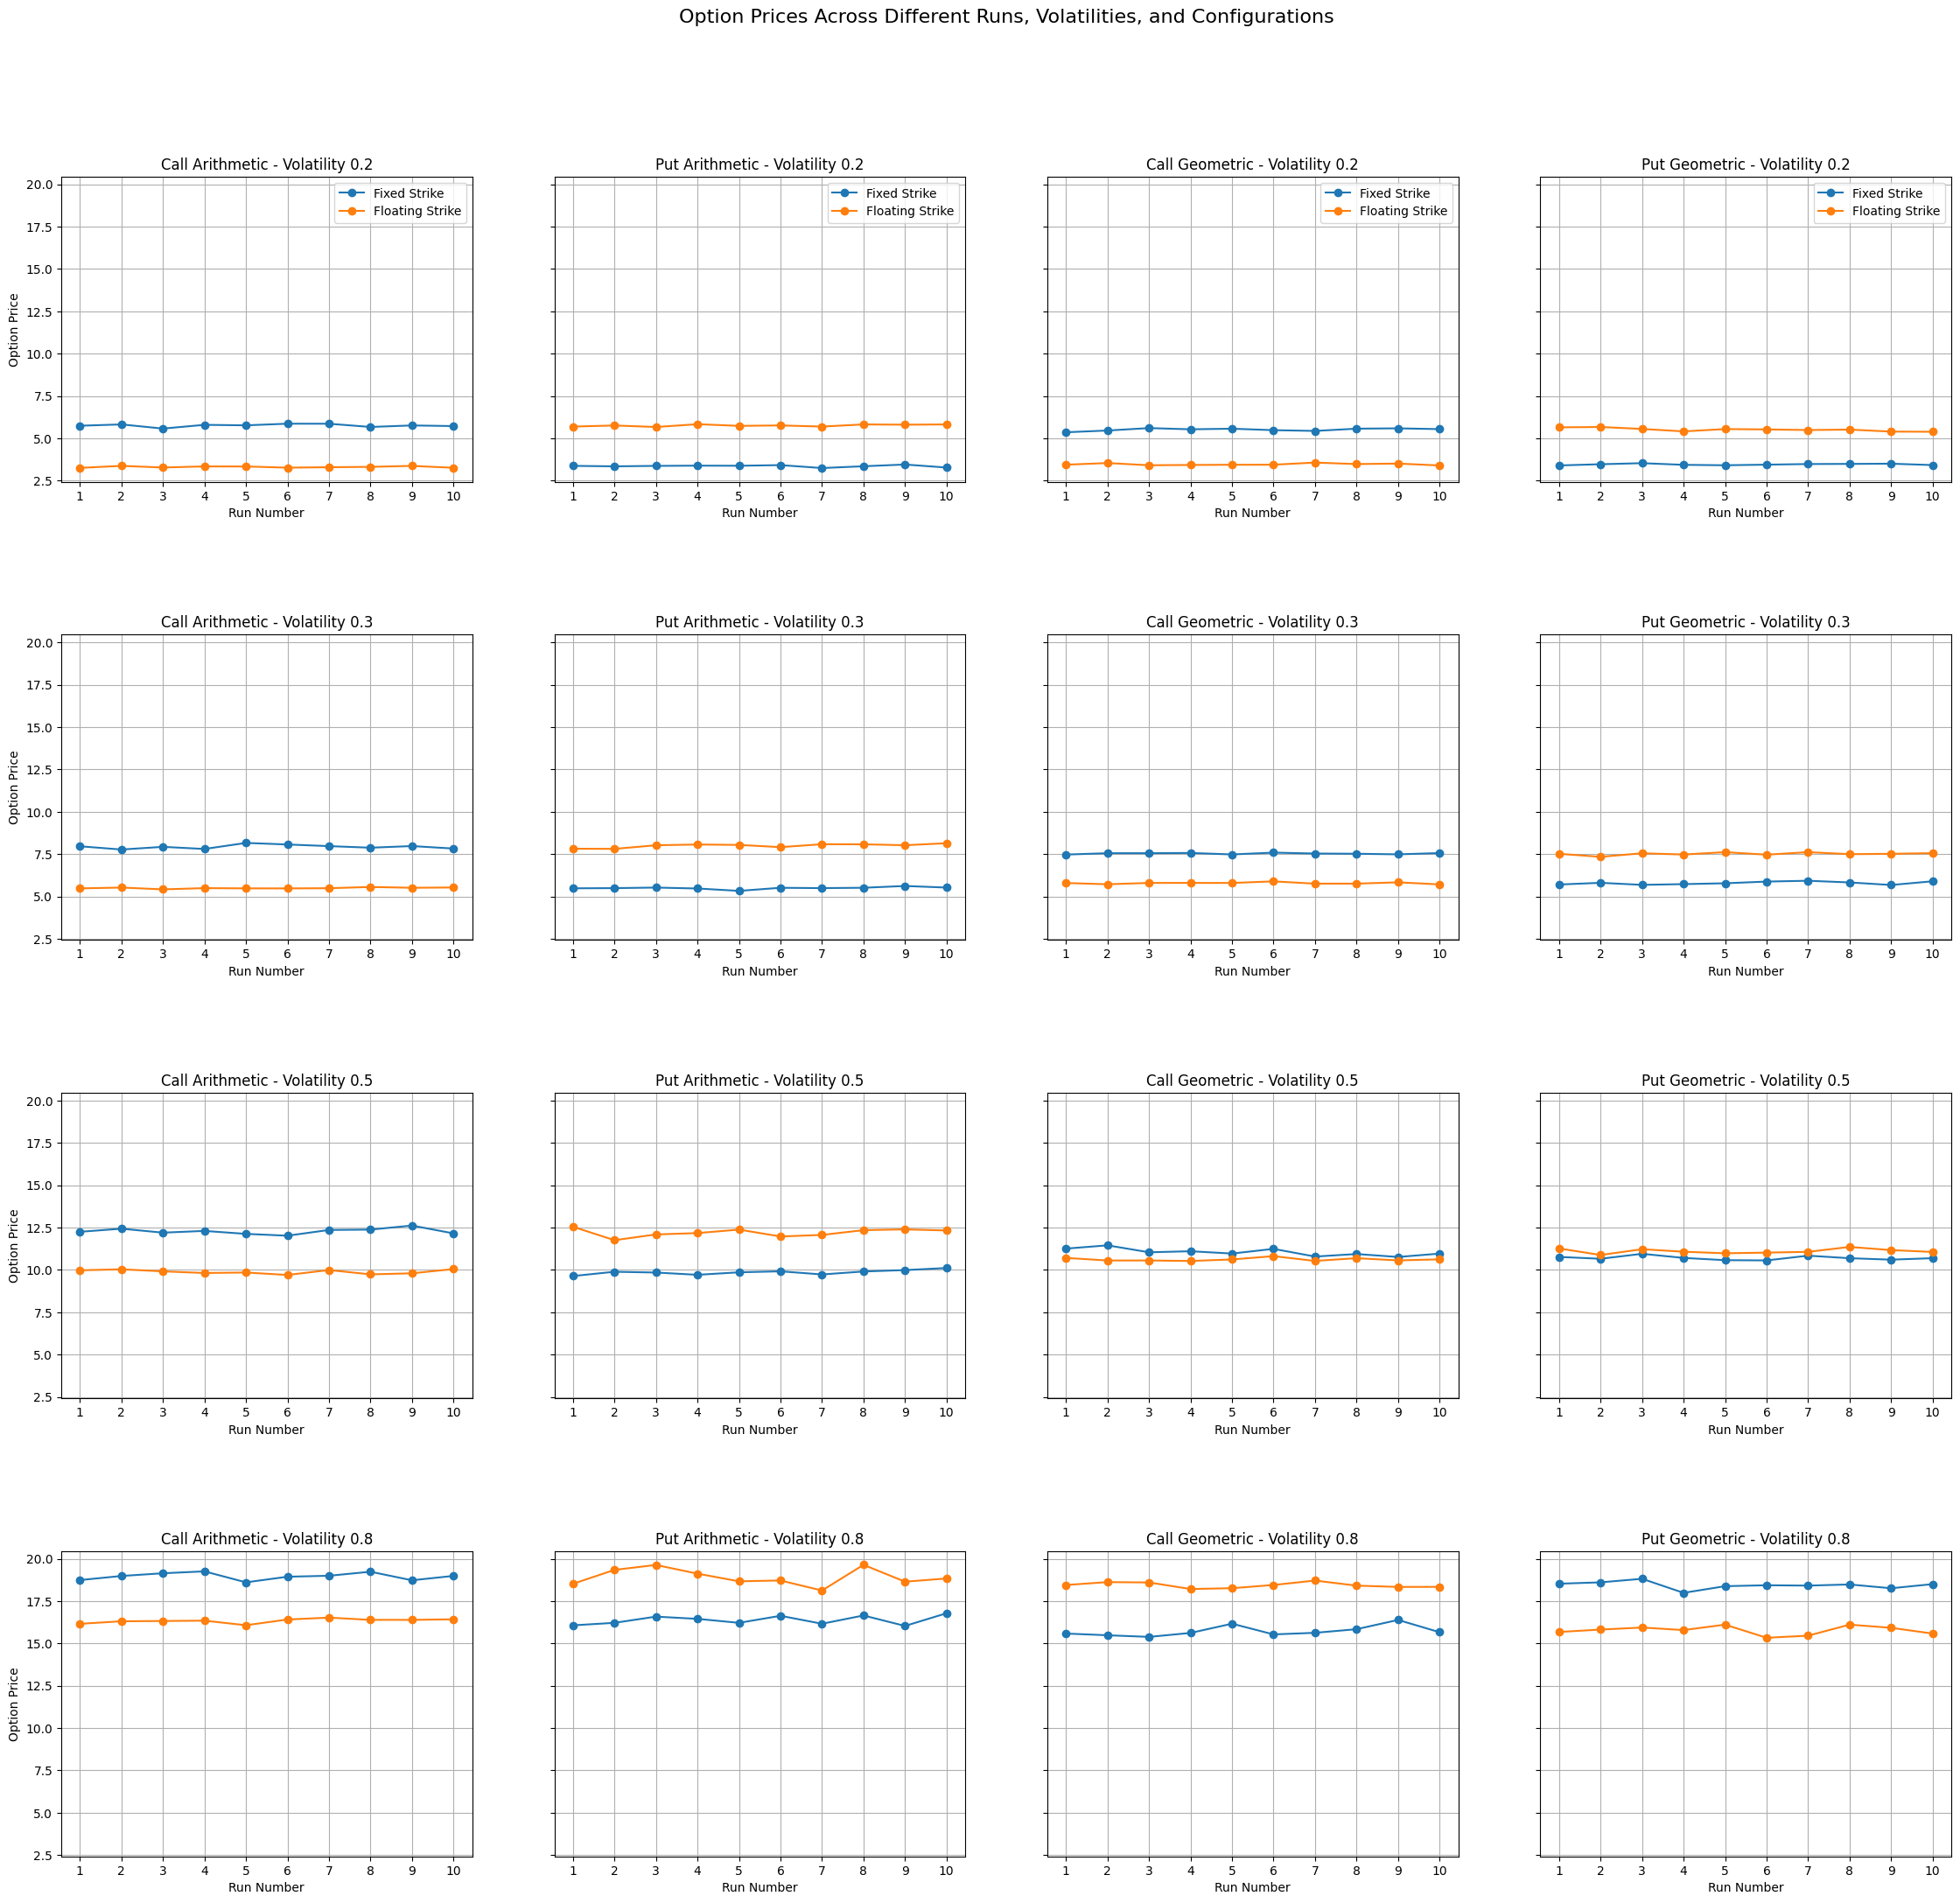

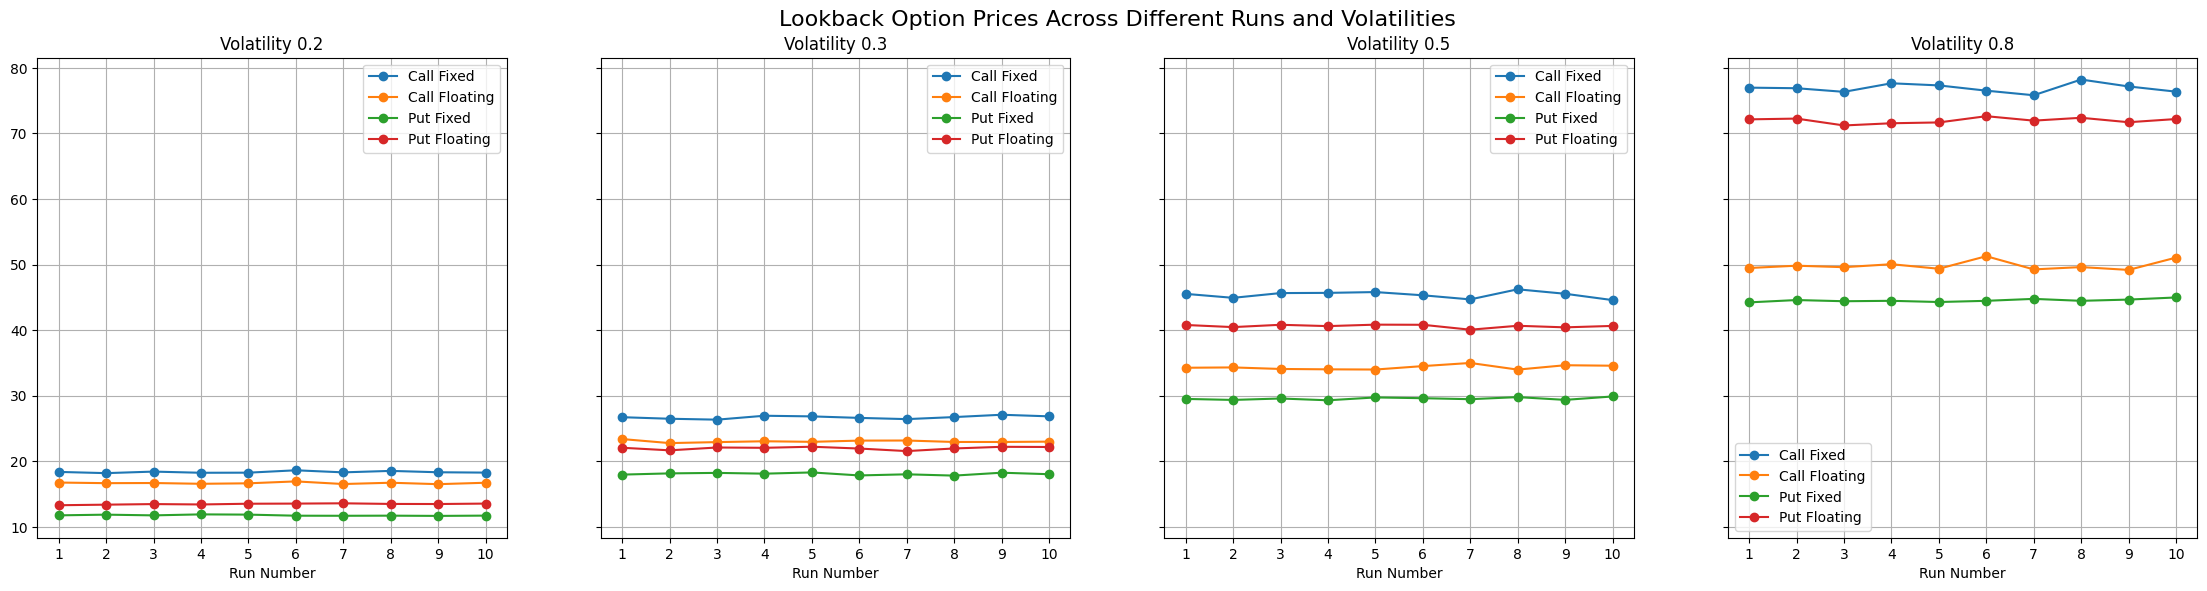

In [21]:
if __name__ == "__main__":
    # Tracker of multiple runs
    tracker = ResultTracker()
    tracker.run_simulations(engine, runs=10)
    # df_agg = tracker.aggregate_results()
    # df_agg.index.name = 'Volatility'
    # print(df_agg)
    tracker.plot_results_asian()
    tracker.plot_results_lookback(tracker.lookback_results, 'Lookback Option Prices Across Different Runs and Volatilities')

### Analytical Solution Trial

Lookback Options

In [24]:
class LookbackOptionPricer:
    #Floating strike
    def __init__(self, config):
        self.config = config
        self.simulator = PathSimulator(config)

    def price_option(self, option_type='call'):
        paths = self.simulator.generate_path()
        S_min = np.min(paths)
        S_max = np.max(paths)
        S = paths[-1]
        sigma = self.config.sigma
        T = self.config.T
        rate = self.config.rate

        a1 = (np.log(S / S_min) + (rate + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        a2 = a1 - sigma * np.sqrt(T)

        if option_type == 'call':
            term1 = S * norm.cdf(a1)
            term2 = S_min * np.exp(-rate * T) * norm.cdf(a2)
            term3 = S * np.exp(-rate * T) * (sigma**2 / (2 * rate)) * ((S/S_min) ** (-2 * rate / sigma**2) * norm.cdf(-a1 + 2 * rate / sigma * np.sqrt(T)) - np.exp(rate * T) * norm.cdf(-a1))
            price = term1 - term2 + term3
        else:  # put

            b1 = (np.log(S / S_max) + (rate + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
            b2 = b1 - sigma * np.sqrt(T)
            term1 = S_max * np.exp(-rate * T) * norm.cdf(-b2)
            term2 = S * norm.cdf(-b1)
            term3 = S * (sigma**2 / (2 * rate)) * np.exp(- rate * T) * (-(S / S_max)**(-2 * rate / sigma **2) *norm.cdf(b1 - 2 * rate / sigma * np.sqrt(T)) + np.exp(rate * T) * norm.cdf(b1))
            price = term1 - term2 + term3

        return price


class LookbackOptionPricer_fix:
    #Fixed strike
    def __init__(self, config, simulator):
        self.config = config
        self.simulator = simulator

    def calculate_d1_d2(self, S, X, sigma, T, b, e1):
        d1 = (np.log(S / X) + (b + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return d1, d2

    def price_call(self):
        path = self.simulator.generate_path()
        S_max = np.max(path)
        X = self.config.strike
        r = self.config.rate
        sigma = self.config.sigma
        T = self.config.T
        b = r  # Assuming b is the cost of carry, here it's the same as the risk-free rate

        if X <= S_max:
            e1 = np.log(S_max / X) + (b + sigma**2 / 2) * T / (sigma * np.sqrt(T))
            d1, d2 = self.calculate_d1_d2(S_max, X, sigma, T, b, e1)
            c = (S_max - X) * self.config.disc + sigma**2 / (2 * b) * (S_max / X - 1) * self.config.disc
        else:
            d1, d2 = self.calculate_d1_d2(X, S_max, sigma, T, b, 0)
            c = (S_max - X) * norm.cdf(d1) - sigma**2 / (2 * b) * (S_max / X - 1) * norm.cdf(d2)

        return c

    def price_put(self):
        path = self.simulator.generate_path()
        S_min = np.min(path)
        X = self.config.strike
        r = self.config.rate
        sigma = self.config.sigma
        T = self.config.T
        b = r  # Assuming b is the cost of carry, here it's the same as the risk-free rate

        if X >= S_min:
            f1 = np.log(S_min / X) + (b + sigma ** 2 / 2) * T / (sigma * np.sqrt(T))
            d1, d2 = self.calculate_d1_d2(X, S_min, sigma, T, b, f1)
            p = (X - S_min) * self.config.disc + sigma ** 2 / (2 * b) * (X / S_min - 1) * self.config.disc
        else:
            d1, d2 = self.calculate_d1_d2(S_min, X, sigma, T, b, 0)
            p = (X - S_min) * norm.cdf(-d1) - sigma ** 2 / (2 * b) * (X / S_min - 1) * norm.cdf(-d2)

        return p

In [30]:
if __name__ == "__main__":
    x = 10000
    np.random.seed(x)
    # config = Config(S0=100, rate=0.05, sigma=0.2, T=1, days=252, dt=1 / 252, strike=100)
    # Configuration arrays
    sigmas = [0.2, 0.5, 0.8]
    strikes = [95, 100, 105]

    # Prepare DataFrame to store results for analytical prices for Lookback options under different configurations
    columns = ['Type', 'Sigma', 'Strike', 'Call Price', 'Put Price']
    results = []

    # Loop through each sigma and strike combination
    for sigma in sigmas:
        for strike in strikes:
            config = Config(S0=100, rate=0.05, sigma=sigma, T=1, days=252, dt=1 / 252, strike=strike)

            # Floating strike pricing
            lookback_pricer = LookbackOptionPricer(config)
            lookback_call_fl = lookback_pricer.price_option('call')
            lookback_put_fl = lookback_pricer.price_option('put')
            results.append(['Floating Strike', sigma, strike, lookback_call_fl, lookback_put_fl])

            # Fixed strike pricing
            simulator = PathSimulator(config)
            fixed_pricer = LookbackOptionPricer_fix(config, simulator)
            call_price = fixed_pricer.price_call()
            put_price = fixed_pricer.price_put()
            results.append(['Fixed Strike', sigma, strike, call_price, put_price])

    # Create DataFrame
    df_results_lookback = pd.DataFrame(results, columns=columns)
    df_sorted_lookback = df_results_lookback.sort_values(by=['Type', 'Sigma', 'Strike'])

    # Print results
    display(df_sorted_lookback)
    # df_sorted_lookback.to_excel(r'C:/Users/aa04947/OneDrive - APG/Desktop/e2cqf_analookbacks.xlsx', index=True)

Type  Sigma  Strike  Call Price   Put Price
1      Fixed Strike    0.2      95   23.449834   21.657713
3      Fixed Strike    0.2     100   13.241534   14.979532
5      Fixed Strike    0.2     105   47.647612   15.428628
7      Fixed Strike    0.5      95  114.921669    8.224792
9      Fixed Strike    0.5     100    9.832100    0.000000
11     Fixed Strike    0.5     105   66.827364    4.875051
13     Fixed Strike    0.8      95   83.935623   52.904317
15     Fixed Strike    0.8     100   35.522791    1.514589
17     Fixed Strike    0.8     105   35.022409   55.051280
0   Floating Strike    0.2      95   20.124563   16.358009
2   Floating Strike    0.2     100   11.913517   25.961205
4   Floating Strike    0.2     105   37.894437   16.793515
6   Floating Strike    0.5      95   31.823300   39.954341
8   Floating Strike    0.5     100   37.881953   77.462758
10  Floating Strike    0.5     105   44.570483   50.527925
12  Floating Strike    0.8      95   48.702864  135.327627
14  Floating Strike    0.8     100   80.842017  221.211971
16  Floating Strike    0.8     105    7.511619   96.585489

Asian Options

In [22]:
class GeometricAsianOptionPricer:
    def __init__(self, config):
        self.config = config
        self.simulator = PathSimulator(config)

    def price_option(self, option_type='call'):
        paths = self.simulator.generate_path()
        S_geo = np.exp(np.mean(np.log(paths)))  # Geometric mean of the simulated path

        # Calculating adjusted volatility and cost-of-carry
        sigma = self.config.sigma
        sigma_A = sigma / np.sqrt(3)
        b_A = 0.5 * (0 - sigma_A ** 2 / 6)

        # Calculate d1 and d2
        d1 = (np.log(S_geo / self.config.strike) + (b_A + 0.5 * sigma_A ** 2) * self.config.T) / (
                    sigma_A * np.sqrt(self.config.T))
        d2 = d1 - sigma_A * np.sqrt(self.config.T)

        # Calculate option price based on type
        # Calculate option price based on type
        if option_type == 'call':
            if S_geo > self.config.strike:
                price = np.exp((b_A - self.config.rate) * self.config.T) * norm.cdf(d1) * S_geo - norm.cdf(
                    d2) * self.config.strike * np.exp(-self.config.rate * self.config.T)
            else:
                price = 0.0  # Call payoff is zero if S_geo <= K
        else:  # put
            if S_geo < self.config.strike:
                price = np.exp((b_A - self.config.rate) * self.config.T) * norm.cdf(
                    -d2) * self.config.strike - norm.cdf(-d1) * S_geo * np.exp(-self.config.rate * self.config.T)
            else:
                price = 0.0  # Put payoff is zero if S_geo >= K

        return price

if __name__ == "__main__":
    x = 10000
    np.random.seed(x)
    config = Config(S0=100, rate=0.05, sigma=0.2, T=1, days=252, dt=1 / 252, strike=100)
    analyt0cal_results_asian = []
    for sigma in sigma_values:
        config = Config(S0=100, rate= 0.05, sigma=sigma, T=1, days=252, dt=1 / 252, strike=100)
        pricer = GeometricAsianOptionPricer(config)
        call_price = pricer.price_option('call')
        put_price = pricer.price_option('put')
        analyt0cal_results_asian.append((sigma, call_price, put_price))
        df_analytical_asian = pd.DataFrame(analyt0cal_results_asian, columns=['Volatility', 'Call Price', 'Put Price'])
        display(df_analytical_asian)

Volatility  Call Price  Put Price
0        0.05    1.254681        0.0

Volatility  Call Price  Put Price
0        0.05    1.254681   0.000000
1        0.20    0.000000  15.573081

Volatility  Call Price  Put Price
0        0.05    1.254681   0.000000
1        0.20    0.000000  15.573081
2        0.30    0.000000  21.301720

Volatility  Call Price  Put Price
0        0.05    1.254681   0.000000
1        0.20    0.000000  15.573081
2        0.30    0.000000  21.301720
3        0.50    0.000000  20.624562

Volatility  Call Price  Put Price
0        0.05    1.254681   0.000000
1        0.20    0.000000  15.573081
2        0.30    0.000000  21.301720
3        0.50    0.000000  20.624562
4        0.60   47.703530  26.062405

Volatility  Call Price  Put Price
0        0.05    1.254681   0.000000
1        0.20    0.000000  15.573081
2        0.30    0.000000  21.301720
3        0.50    0.000000  20.624562
4        0.60   47.703530  26.062405
5        0.80   73.411046  17.509256

Volatility  Call Price  Put Price
0        0.05    1.254681   0.000000
1        0.20    0.000000  15.573081
2        0.30    0.000000  21.301720
3        0.50    0.000000  20.624562
4        0.60   47.703530  26.062405
5        0.80   73.411046  17.509256
6        1.00    0.000000  44.158729

### Uncertain Volatility Model I
This model is only used to experiment the price of lookback options -Parametric approach

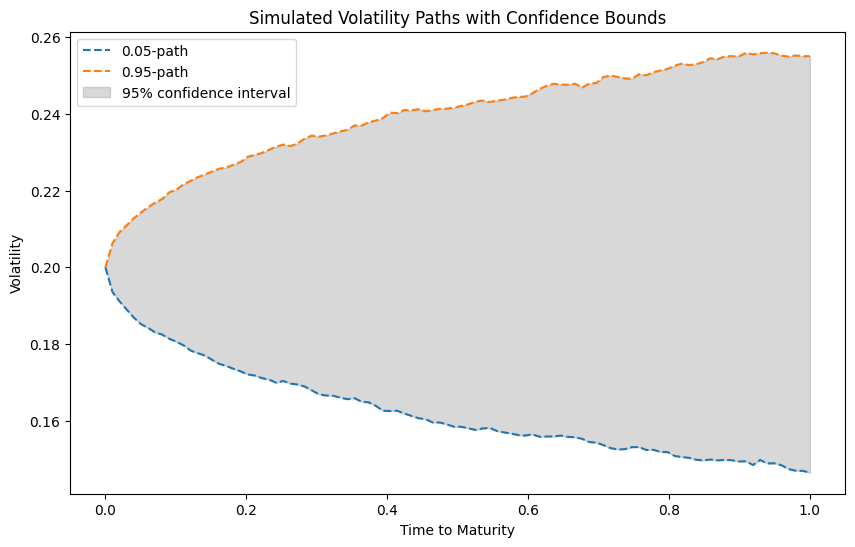

Strike Type Option Type  Strike      Price
2        Fixed        Call      95  22.643269
6        Fixed        Call     100  17.737619
10       Fixed        Call     105  13.693599
3        Fixed         Put      95   7.450373
7        Fixed         Put     100  11.406673
11       Fixed         Put     105  16.035345
0     Floating        Call      95  16.406234
4     Floating        Call     100  16.030404
8     Floating        Call     105  16.325556
1     Floating         Put      95  12.864979
5     Floating         Put     100  13.113889
9     Floating         Put     105  12.824398

In [40]:
# This is another config which incorproates the uncertain Heston model
class Config:
    def __init__(self, kappa, theta, sigma, sigma0, T, dt, n_paths=1000, S0=100, rate=0.05, strike=100,
                 disc=np.exp(-0.05)):
        self.kappa = kappa  # Mean reversion rate of volatility
        self.theta = theta  # Long-term mean volatility
        self.sigma = sigma  # Volatility of volatility
        self.sigma0 = sigma0  # Initial volatility
        self.T = T  # Time to maturity
        self.dt = dt  # Time increment
        self.n_paths = n_paths  # Number of paths to simulate
        self.alpha_range = np.linspace(0.01, 0.99, n_paths)
        self.S0 = S0  # Initial stock price
        self.rate = rate  # Risk-free rate
        self.strike = strike  # Strike price for the option
        self.disc = disc  # Discount factor


class UncertainVol1:
    def __init__(self, config):
        self.config = config

    def simulate_paths(self):
        n_steps = int(self.config.T / self.config.dt)
        times = np.linspace(0, self.config.T, n_steps)
        sigma_paths = np.zeros((self.config.n_paths, n_steps))
        sigma_paths[:, 0] = self.config.sigma0

        for i in range(1, n_steps):
            dW = np.random.standard_normal((self.config.n_paths,))
            for j in range(self.config.n_paths):
                alpha = self.config.alpha_range[j]
                uncertainty_increment = self.sqrt_3_over_pi_ln(alpha) * np.sqrt(self.config.dt)
                drift = self.config.kappa * (self.config.theta - sigma_paths[j, i - 1]) * self.config.dt
                diffusion = self.config.sigma * uncertainty_increment * dW[j] * np.sqrt(max(sigma_paths[j, i - 1], 0))
                sigma_paths[j, i] = sigma_paths[j, i - 1] + drift + diffusion

        # Calculate low and high paths after all updates
        sorted_sigma_paths = np.sort(sigma_paths, axis=0)
        low_path = sorted_sigma_paths[int(0.05 * self.config.n_paths), :]  # 5th percentile path
        high_path = sorted_sigma_paths[int(0.95 * self.config.n_paths), :]  # 95th percentile path

        return times, low_path, high_path, sigma_paths

    def sqrt_3_over_pi_ln(self, alpha):
        """ Calculate the uncertainty increment factor based on alpha. """
        return (np.sqrt(3) / np.pi) * np.log(alpha / (1 - alpha))



class PathSimulator:
    def __init__(self, config, sigma_paths):
        self.config = config
        self.sigma_paths = sigma_paths  # Ensure this is a 2D array: shape (n_paths, n_steps)

    def generate_paths(self):
        n_steps = int(self.config.T / self.config.dt)
        S_paths = np.zeros((self.config.n_paths, n_steps))
        S_paths[:, 0] = self.config.S0

        for i in range(1, n_steps):
            dZ = np.random.standard_normal((self.config.n_paths,))  # Random shocks for each path
            # Correct handling of sigma_paths (2D array expected)
            drift = (self.config.rate - 0.5 * self.sigma_paths[:, i-1] ** 2) * self.config.dt
            diffusion = self.sigma_paths[:, i-1] * np.sqrt(self.config.dt) * dZ
            S_paths[:, i] = S_paths[:, i-1] * np.exp(drift + diffusion)

        return S_paths



class LookbackOptionPricer:
    def __init__(self, config):
        self.config = config

    def price_option(self, S_paths, option_type="call", strike_type="floating"):
        if strike_type == "floating":
            if option_type == "call":
                payoffs = np.maximum(S_paths[:, -1] - np.min(S_paths, axis=1), 0)
            elif option_type == "put":
                payoffs = np.maximum(np.max(S_paths, axis=1) - S_paths[:, -1], 0)
        else: #fixed
            if option_type == "call":
                payoffs = np.maximum(np.max(S_paths, axis=1) - self.config.strike, 0)
            elif option_type == "put":
                payoffs = np.maximum(self.config.strike - np.min(S_paths, axis=1), 0)

        return np.mean(payoffs) * self.config.disc


if __name__ == "__main__":
    np.random.seed(0)
    config = Config(kappa=0.3, theta=0.2, sigma=0.1, sigma0=0.2, T=1, dt=0.01, n_paths=10000)
    uncertain_sim = UncertainVol1(config)
    simulator = UncertainVol1(config)
    times, low_path, high_path, sigma_paths = uncertain_sim.simulate_paths()

    path_sim = PathSimulator(config, sigma_paths)
    S_paths = path_sim.generate_paths()

    #Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(times, low_path, label='0.05-path', linestyle='--')
    plt.plot(times, high_path, label='0.95-path', linestyle='--')
    plt.fill_between(times, low_path, high_path, color='gray', alpha=0.3, label='95% confidence interval')
    plt.title("Simulated Volatility Paths with Confidence Bounds")
    plt.xlabel("Time to Maturity")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()


    # option_pricer = LookbackOptionPricer(config)
    # price_flc = option_pricer.price_option(S_paths, option_type="call", strike_type="floating")
    # print(f"The price of the floating lookback call option is: {price_flc:.2f}")
    # price_flp = option_pricer.price_option(S_paths, option_type="put", strike_type="floating")
    # print(f"The price of the floating lookback put option is: {price_flp:.2f}")
    # price_fxc = option_pricer.price_option(S_paths, option_type="call", strike_type="fixed")
    # print(f"The price of the floating lookback call option is: {price_fxc:.2f}")
    # price_fxp = option_pricer.price_option(S_paths, option_type="put", strike_type="fixed")
    # print(f"The price of the floating lookback put option is: {price_fxp:.2f}")

    strikes = [95, 100, 105]
    results = []

    # Common configuration and simulator initialization
    # config = Config(kappa=0.3, theta=0.2, sigma=0.1, sigma0=0.2, T=1, dt=0.01, n_paths=10000)
    uncertain_sim = UncertainVol1(config)
    times, low_path, high_path, sigma_paths = uncertain_sim.simulate_paths()

    for strike in strikes:
        config.strike = strike  # Update the strike price in the configuration
        # Generate stock paths with updated configuration
        path_sim = PathSimulator(config, sigma_paths)
        S_paths = path_sim.generate_paths()
        # Price options for both floating and fixed strikes for call and put
        option_pricer = LookbackOptionPricer(config)
        price_flc = option_pricer.price_option(S_paths, option_type="call", strike_type="floating")
        price_flp = option_pricer.price_option(S_paths, option_type="put", strike_type="floating")
        price_fxc = option_pricer.price_option(S_paths, option_type="call", strike_type="fixed")
        price_fxp = option_pricer.price_option(S_paths, option_type="put", strike_type="fixed")

        # Append results to the list
        results.append(['Floating', 'Call', strike, price_flc])
        results.append(['Floating', 'Put', strike, price_flp])
        results.append(['Fixed', 'Call', strike, price_fxc])
        results.append(['Fixed', 'Put', strike, price_fxp])

    # Create DataFrame from results
    df_results_ude = pd.DataFrame(results, columns=['Strike Type', 'Option Type', 'Strike', 'Price'])
    df_results_ude = df_results_ude.sort_values(by=['Strike Type', 'Option Type', 'Strike'])

    # Display the DataFrame
    display(df_results_ude)

## Uncertain Volatility Model II
Non parametric 

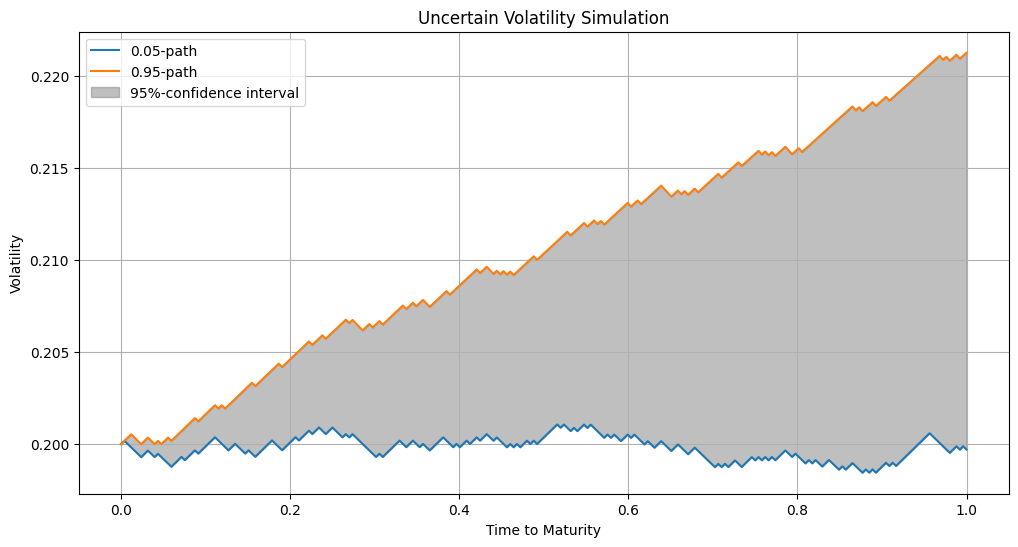

Strike Type Option Type  Strike  Price_uncertain_vol_i  \
0        Fixed        Call      95              22.643269   
1        Fixed        Call     100              17.737619   
2        Fixed        Call     105              13.693599   
3        Fixed         Put      95               7.450373   
4        Fixed         Put     100              11.406673   
5        Fixed         Put     105              16.035345   
6     Floating        Call      95              16.406234   
7     Floating        Call     100              16.030404   
8     Floating        Call     105              16.325556   
9     Floating         Put      95              12.864979   
10    Floating         Put     100              13.113889   
11    Floating         Put     105              12.824398   

    Price_uncertain_vol_ii  
0                16.459583  
1                11.759206  
2                 6.939638  
3                 0.005221  
4                 2.925606  
5                 7.881133  
6                 2.154061  
7                 0.595221  
8                 0.242666  
9                 6.565777  
10               12.374640  
11               13.505494

In [42]:
# Another different config settings for this specific uncertain volatility model
class Config:
    def __init__(self, S0, rate, strike, disc, T, steps):
        self.S0 = S0  # Initial stock price
        self.rate = rate  # Risk-free rate
        self.strike = strike  # Strike price for the option
        self.disc = disc  # Discount factor
        self.T = T  # Total time period for the simulation
        self.steps = steps  # Number of steps in the simulation

class UncertainVol2:
    def __init__(self, initial_volatility, kappa, theta, sigma, T, steps):
        self.initial_volatility = initial_volatility
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.T = T
        self.steps = steps

    def generate_paths(self):
        dt = self.T / self.steps
        times = np.linspace(0, self.T, self.steps + 1)
        vol_paths = np.zeros((self.steps + 1, 2))  # For min and max paths
        vol_paths[0, :] = self.initial_volatility

        for i in range(1, self.steps + 1):
            # Generate Liu process increments (simple simulation)
            # dC = np.random.uniform(-1, 1, size=2)  # Simulating uncertainty increments
            dC = np.sign(np.random.rand(2) - 0.5) * np.sqrt(dt)  # Simulating Liu process increments
            dC[1] = max(dC)  # Ensuring the .95-path increment is the maximum
            dC[0] = min(dC)  # Ensuring the .05-path increment is the minimum

            # Apply the uncertain model dynamics
            vol_paths[i, :] = vol_paths[i - 1, :] + self.kappa * (self.theta - vol_paths[i - 1, :]) * dt + \
                              self.sigma * np.sqrt(np.maximum(vol_paths[i - 1, :], 0)) * dC * np.sqrt(dt)

        return times, vol_paths

class StockPathSimulator:
    def __init__(self, config, vol_paths):
        self.config = config
        self.vol_paths = vol_paths

    def generate_paths(self):
        dt = self.config.T / self.config.steps
        times = np.linspace(0, self.config.T, self.config.steps + 1)
        stock_paths = np.zeros((self.config.steps + 1, 2))
        stock_paths[0, :] = self.config.S0

        for i in range(1, self.config.steps + 1):
            dZ = np.random.normal(size=2)
            stock_paths[i, :] = stock_paths[i - 1, :] * np.exp(
                (self.config.rate - 0.5 * self.vol_paths[i - 1, :] ** 2) * dt +
                self.vol_paths[i - 1, :] * np.sqrt(dt) * dZ)

        return times, stock_paths

class LookbackOptionPricer:
    def __init__(self, config):
        self.config = config

    def price_option(self, S_paths, option_type="call", strike_type="floating"):
        if strike_type == "floating":
            if option_type == "call":
                payoffs = np.maximum(S_paths[:, -1] - np.min(S_paths, axis=1), 0)
            elif option_type == "put":
                payoffs = np.maximum(np.max(S_paths, axis=1) - S_paths[:, -1], 0)
        else:  # fixed
            if option_type == "call":
                payoffs = np.maximum(np.max(S_paths, axis=1) - self.config.strike, 0)
            elif option_type == "put":
                payoffs = np.maximum(self.config.strike - np.min(S_paths, axis=1), 0)

        return np.mean(payoffs) * self.config.disc

class VolatilityPlot:
    def __init__(self, model):
        self.model = model

    def plot_volatility(self):
        times, vol_paths = self.model.generate_paths()
        plt.figure(figsize=(12, 6))
        plt.plot(times, vol_paths[:, 0], label='0.05-path')
        plt.plot(times, vol_paths[:, 1], label='0.95-path')
        plt.fill_between(times, vol_paths[:, 0], vol_paths[:, 1], color='gray', alpha=0.5,
                         label='95%-confidence interval')
        plt.title('Uncertain Volatility Simulation')
        plt.xlabel('Time to Maturity')
        plt.ylabel('Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example usage
# model = UncertainVolatilityModel(initial_volatility=0.2, kappa=1, theta=0.2, sigma=0.1, T=1, steps=100)
if __name__ == "__main__":
    config = Config(S0=100, rate=0.05, strike=100, disc=np.exp(-0.05 * 1), T=1, steps=252)
    uv_model = UncertainVol2(initial_volatility=0.2, kappa=0.3, theta=0.2, sigma=0.1, T=1, steps=252)
    times, vol_paths = uv_model.generate_paths()

    stock_sim = StockPathSimulator(config, vol_paths)
    _, stock_paths = stock_sim.generate_paths()

    volatility_plot = VolatilityPlot(uv_model)
    volatility_plot.plot_volatility()

    # Define the experiment strike prices
    strikes = [95, 100, 105]
    results = []  # List to store results for DataFrame
    for strike in strikes:
        config = Config(S0=100, rate= config.rate, strike= strike, disc= config.disc, T= config.T, steps= config.steps)
        uv_model = UncertainVol2(initial_volatility= uv_model.initial_volatility, kappa= uv_model.kappa, theta= uv_model.theta,
                                 sigma= uv_model.sigma, T= uv_model.T, steps= uv_model.steps)
        _, vol_paths = uv_model.generate_paths()

        stock_sim = StockPathSimulator(config, vol_paths)
        _, stock_paths = stock_sim.generate_paths()

        option_pricer = LookbackOptionPricer(config)
        price_call_floating = option_pricer.price_option(stock_paths, option_type="call", strike_type="floating")
        price_put_floating = option_pricer.price_option(stock_paths, option_type="put", strike_type="floating")
        price_call_fixed = option_pricer.price_option(stock_paths, option_type="call", strike_type="fixed")
        price_put_fixed = option_pricer.price_option(stock_paths, option_type="put", strike_type="fixed")

        # Append results to the list for each strike
        results.append(['Floating', 'Call', strike, price_call_floating])
        results.append(['Floating', 'Put', strike, price_put_floating])
        results.append(['Fixed', 'Call', strike, price_call_fixed])
        results.append(['Fixed', 'Put', strike, price_put_fixed])

    # Create DataFrame from results
    df_results = pd.DataFrame(results, columns=['Option Type', 'Call or Put', 'Strike', 'Price'])
    # Create DataFrame from results
    df_results_nuv = pd.DataFrame(results, columns=['Strike Type', 'Option Type', 'Strike', 'Price'])
    df_results_nuv = df_results_nuv.sort_values(by=['Strike Type', 'Option Type', 'Strike'])
    # display(df_results_nuv)

    #Merge the results from uncertain volatility model II with the result dataframe from Uncertain differential equation approach
    merged_df = pd.merge(df_results_ude, df_results_nuv, on=['Strike Type', 'Option Type', 'Strike'], suffixes=('_uncertain_vol_i', '_uncertain_vol_ii'))
    merged_df = merged_df.sort_values(by=['Strike Type', 'Option Type', 'Strike'])
    display(merged_df)
    # merged_df.to_excel(r'C:/Users/aa04947/OneDrive - APG/Desktop/e2cqf_uv.xlsx', index=True)


### Surface and Contour Plots for Function min(u,v)
Section 6.1 in the report 

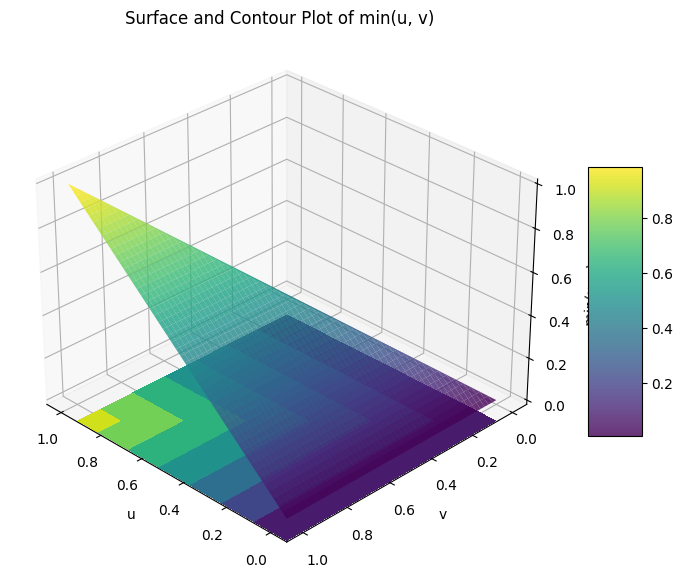

In [10]:
# Setting the interval values
t = 0
T = 1

# Generating values for u and v between t and T
u = np.linspace(t, T, 400)
v = np.linspace(t, T, 400)

U, V = np.meshgrid(u, v)
Min_uv = np.minimum(U, V)

# Plotting the min(u, v) surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(U, V, Min_uv, cmap='viridis', edgecolor='none', alpha=0.8)
cset = ax.contourf(U, V, Min_uv, zdir='z', offset=t-0.1, cmap='viridis')

# Labels and title
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('min(u, v)')
ax.set_title('Surface and Contour Plot of min(u, v)')

# Setting view angle for better visualization
ax.view_init(elev=30, azim=135)

# Color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Showing the plot
plt.show()
